# Radial Distribution Function - Simple Example and Description
The radial distribution function measures the clustering of objects as a function of distance. 

As an example let us load a typical cloud field.

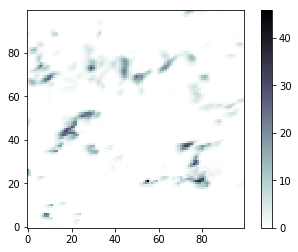

In [15]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmo_utils.pyncdf import getfobj_ncdf
fn = '/project/meteo/scratch/users/stephan.rasp/convective_variability_data/raw_data/2016060500/deout_ceu_pspens/det/OUTPUT/lfff00150000.nc_30m_surf'
prec_field = getfobj_ncdf(fn, 'PREC_ACCUM').data
plt.imshow(prec_field[100:200, 100:200], cmap='bone_r', origin='lower')
plt.colorbar()

The first step is to create a binary field using a threshold. For precipitation I am using a threshold of 1 mm/h. Then we can identify continuous objects as grid points which share a common border. Insporation comes from this great example: https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/

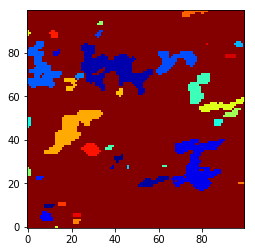

In [30]:
from cosmo_utils.diag import identify_clouds
threshold = 1.
labels = identify_clouds(prec_field, threshold, water=False)[0]
# Shuffle data to make more visible
b = np.arange(labels.max() + 1)
np.random.shuffle(b)
shuffledLw = b[labels]
plt.imshow(shuffledLw[100:200, 100:200], cmap='jet', origin='lower')

### Cloud separation
We can also further separate the identified objects using a local maximum filter. This filter identifies the local maxima for each object. From these maxima a watershed algorith is used to define the extent of each sub-object.

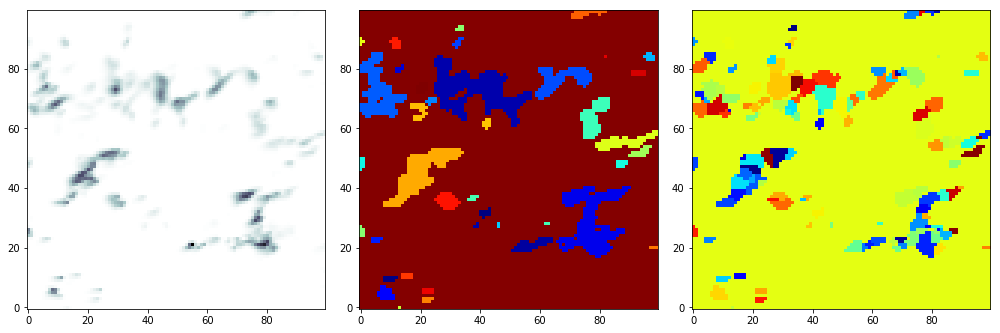

In [31]:
labels_sep = identify_clouds(prec_field, threshold, water=True)[0]
# Shuffle data to make more visible
b = np.arange(labels_sep.max() + 1)
np.random.shuffle(b)
shuffledLw_sep = b[labels_sep]
fig, axarr = plt.subplots(1, 3, figsize=(14, 5))
axarr[0].imshow(prec_field[100:200, 100:200], cmap='bone_r', origin='lower')
axarr[1].imshow(shuffledLw[100:200, 100:200], cmap='jet', origin='lower')
axarr[2].imshow(shuffledLw_sep[100:200, 100:200], cmap='jet', origin='lower')
plt.tight_layout()

As you can see, the cloud separation algorithm separates the clouds very agressively. It certainly seems like some of the separated cloud objects are too small. The unseparated cloud objects, on the other, hand appear to be too large. Of course, some tuning could be done with the threshold. But which value to chose?

## Computing the RDF
The first step to compute the RDF is compute the centers of mass of each identified object. This is already done inside the calc_rdf() function. 

Then we have to define some parameters:

1. The maximum search radius **r_max**
2. The bin size **dr**

In [36]:
import sys
sys.path.append('../python_scripts')
from helpers import calc_rdf, pair_correlation_2d

r_max = 30   # In grid points
dr = 1       # Also in grid points

rdf, radii = calc_rdf(labels, prec_field, normalize=False, dx=2.8e3, r_max=r_max, dr=dr)

The function outputs the radial distribution function and the radii. The unit of the non-normalized radial distribution function is 

In [41]:
from inspect import getsourcelines
print(''.join(getsourcelines(pair_correlation_2d)[0]))

def pair_correlation_2d(x, y, S, r_max, dr, normalize=True, mask=None):
    """
    Need new doc string
    
    https://github.com/cfinch/colloid/blob/master/adsorption/analysis.py
    
    Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius r_max drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller r_max...or write some code to handle edge effects! ;)
    
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        r_max            outer diameter of larges

In [ ]:
def pair_correlation_2d(x, y, S, r_max, dr, normalize=True, mask=None):
    """
    Need new doc string
    
    https://github.com/cfinch/colloid/blob/master/adsorption/analysis.py
    
    Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius r_max drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller r_max...or write some code to handle edge effects! ;)
    
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        r_max            outer diameter of largest annulus
        dr              increment for increasing radius of annulus
    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
    """

    # Number of particles in ring/area of ring/number of reference
    # particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Extract domain size
    (Sx,Sy) = S if len(S) == 2 else (S, S)

    # Find particles which are close enough to the box center that a circle of radius
    # r_max will not cross any edge of the box

    # Find indices within boundaries
    if mask is None:
        bools1 = x > r_max
        bools2 = x < (Sx - r_max)
        bools3 = y > r_max
        bools4 = y < (Sy - r_max)
        interior_indices, = np.where(bools1 * bools2 * bools3 * bools4)
    else:
        # Get closes indices for parcels in a pretty non-pythonic way
        # and check whether it is inside convolved mask
        x_round = np.round(x)
        y_round = np.round(y)
        interior_indices = []
        for i in range(x_round.shape[0]):
            if mask[int(x_round[i]), int(y_round[i])] == 1:
                interior_indices.append(i)

    num_interior_particles = len(interior_indices)

    edges = np.arange(0., r_max + dr, dr)   # Was originally 1.1?
    num_increments = len(edges) - 1
    g = np.zeros([num_interior_particles, num_increments])
    radii = np.zeros(num_increments)
    number_density = float(len(x)) / float(Sx*Sy)

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = np.sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * r_max   # Because sqrt(0)

        result, bins = np.histogram(d, bins=edges, normed=False)
        if normalize:
            result = result/number_density
        g[p, :] = result

    # Average g(r) for all interior particles and compute radii
    g_average = np.zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = np.mean(g[:, i]) / (np.pi * (rOuter**2 - rInner**2))

    return g_average, radii, interior_indices


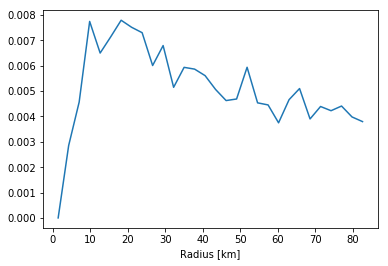

In [34]:
plt.plot(radii / 1000., rdf)   # Convert radii from m to km
plt.xlabel('Radius [km]')